In [1]:
## Import necessary libraries 
import os
import random
import cv2
import numpy as np
import random
import math
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab.patches import cv2_imshow
%matplotlib inline


In [2]:
# Download Data
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 93.4MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 63.7MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


In [3]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1], 
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
  
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [4]:
def get_keymatch(img1, img2):
  sift = cv2.xfeatures2d.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des1,des2,k=2)
  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75*n.distance:
          good.append(m)
  return good, kp1, kp2


def normalize(img1, img2, good, kp1, kp2):
  x1 = [i for i in range(img1.shape[1])]
  y1 = [i for i in range(img1.shape[0])]
  x2 = [i for i in range(img2.shape[1])]
  y2 = [i for i in range(img2.shape[0])]
 
  T1 = np.array([[1/np.std(x1),     0   , -np.mean(x1)/np.std(x1)],
                [    0    , 1/np.std(y1), -np.mean(y1)/np.std(y1)],
                [    0    ,     0   ,        1       ]])
  T2 = np.array([[1/np.std(x2),     0   , -np.mean(x2)/np.std(x2)],
                [    0    , 1/np.std(y2), -np.mean(y2)/np.std(y2)],
                [    0    ,     0   ,        1       ]])
  
  x1_hat, y1_hat, x2_hat, y2_hat=[],[],[],[]

  for i in range(len(good)):
    # print(good[i].queryIdx)
    x_1, y_1= kp1[good[i].queryIdx].pt
    x_2, y_2= kp2[good[i].trainIdx].pt
    src= np.array([x_1, y_1, 1]).reshape(-1,1)
    dst= np.array([x_2, y_2, 1]).reshape(-1,1)
    tmp1 = T1 @ src
    tmp2 = T2 @ dst
    x1_hat.append(tmp1[0][0])
    y1_hat.append(tmp1[1][0])
    x2_hat.append(tmp2[0][0])
    y2_hat.append(tmp2[1][0])

  x1_hat= np.array(x1_hat).reshape(-1, 1)
  y1_hat= np.array(y1_hat).reshape(-1, 1)
  x2_hat= np.array(x2_hat).reshape(-1, 1)
  y2_hat= np.array(y2_hat).reshape(-1, 1)

  return T1, T2, x1_hat, y1_hat, x2_hat, y2_hat




def inlier(x1, y1, x2, y2, H):
  inliers=0
  for i in range(x1.shape[0]):
    src, dst= [], []
    src.append((x1[i][0],y1[i][0]))
    src= np.array(src).reshape(-1, 2)
    dst.append((x2[i][0],y2[i][0]))
    dst= np.array(dst).reshape(-1, 2)

    new_dst= apply_homography(H, src)
    dist= np.linalg.norm(dst - new_dst)
    if dist<0.001:
      # print(dist)
      inliers+=1
  # print('Final length:', len(inliers))
  return inliers


# Compute Ransac to get 4 points and possible best H matrix
def ransacH(x1, y1, x2, y2):
  # Find normalization matrix
  # Transform point set 1 and 2
  # RANSAC based 8-point algorithm
  samp= random.sample(range(0, x1.shape[0]), 4)

  src, dst=[], []
  for i in samp:
    src.append((x1[i][0], y1[i][0]))
    dst.append((x2[i][0], y2[i][0]))

  src= np.array(src).reshape(-1, 2)
  dst= np.array(dst).reshape(-1, 2)
  
  # Compute Homography matrix
  H,_= cv2.findHomography(src, dst)

  return H, samp

def warp_img(img1, img2, H):

  #Create a canvas to accomodate all images
  canvas = np.ones((img1.shape[0], img1.shape[1]+img2.shape[1], 3))*255

  src_pts =  np.mgrid[0:img1.shape[1]:0.1, 0:img1.shape[0]:0.1]
  src_pts = np.transpose(src_pts.reshape((2, -1)))

  dst_pts = apply_homography(final_H, src_pts)
  canvas[:, -img2.shape[1]:, :] = img2
  for i in range(dst_pts.shape[0]):
    proj_row = int(dst_pts[i][1])
    proj_col = int(dst_pts[i][0]+img1.shape[1])
    if (proj_row < 0) or (proj_col < 0) or (proj_row > img1.shape[0]-1) or (proj_col > img1.shape[1]+img2.shape[1]-1):
      continue
    canvas[proj_row, proj_col] = img1[int(src_pts[i][1]), int(src_pts[i][0])]
  canvas = canvas.astype(np.uint8)
  return canvas



denormalized matrix, first warp: [[ 1.06139429e+00 -5.78131765e-02 -1.53845271e+02]
 [ 1.02914319e-01  1.01086067e+00 -2.90292642e+00]
 [ 3.29452141e-04 -7.09809202e-05  9.44885945e-01]]


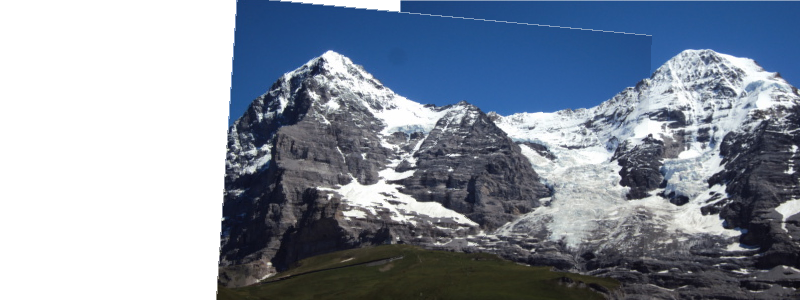

denormalized matrix, second warp: [[ 1.12241421e+00 -1.61055093e-02 -6.01300035e+02]
 [ 6.12087257e-02  1.07308750e+00 -1.59923796e+01]
 [ 3.13592642e-04 -6.12799375e-05  8.83881090e-01]]


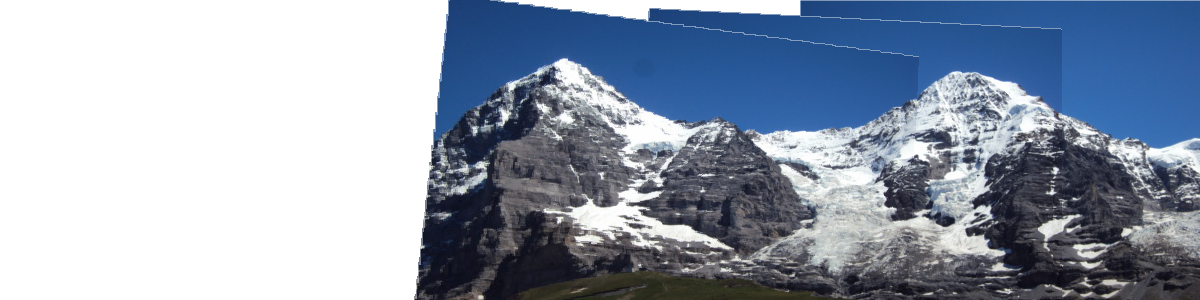

In [5]:
image1= cv2.imread('/content/hill/1.JPG')
image2= cv2.imread('/content/hill/2.JPG')
image3= cv2.imread('/content/hill/3.JPG')

for i in range(2):
  good, kp1, kp2= get_keymatch(image1, image2)
  T1, T2, x1_hat, y1_hat, x2_hat, y2_hat = normalize(image1, image2, good, kp1, kp2)
  
  max_matches=0
  max_iters=1000
  best_H= np.zeros((3,3))
  for it in range(max_iters):
    H, ind= ransacH(x1_hat, y1_hat, x2_hat, y2_hat)
    matches= inlier(x1_hat, y1_hat, x2_hat, y2_hat, H)
    if matches> max_matches:
      max_matches= matches
      final_ind=ind
      # print("Iter:", it, "match length:", max_matches)
      # print('------')
      best_H= H
  # print('Normalized H:', best_H)
  final_H= np.linalg.inv(T2.astype(np.float64)) @ best_H @ T1
  st_img= warp_img(image1, image2, final_H)
  if i !=1:
    print('denormalized matrix, first warp:',final_H)
    image1= st_img
    image2= image3
    cv2_imshow(st_img)  
  else:
    print('denormalized matrix, second warp:',final_H)
    res=st_img
    cv2_imshow(res)


denormalized matrix, first warp: [[ 1.22364219e+00  2.33303463e-02 -3.30681626e+02]
 [ 2.82874446e-01  1.12008144e+00 -1.06188285e+02]
 [ 9.60502814e-04  1.96567608e-05  7.63679241e-01]]


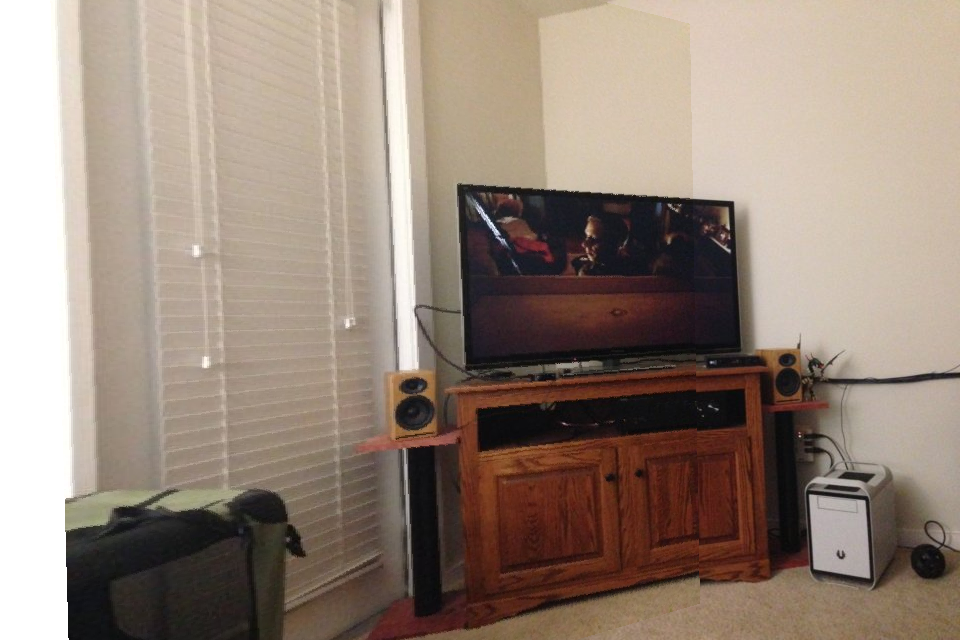

denormalized matrix, second warp: [[ 1.36875714e+00  2.07117702e-02 -9.46106888e+02]
 [ 2.31351751e-01  1.26712555e+00 -1.89980760e+02]
 [ 7.91934603e-04  1.26656176e-05  6.16220693e-01]]


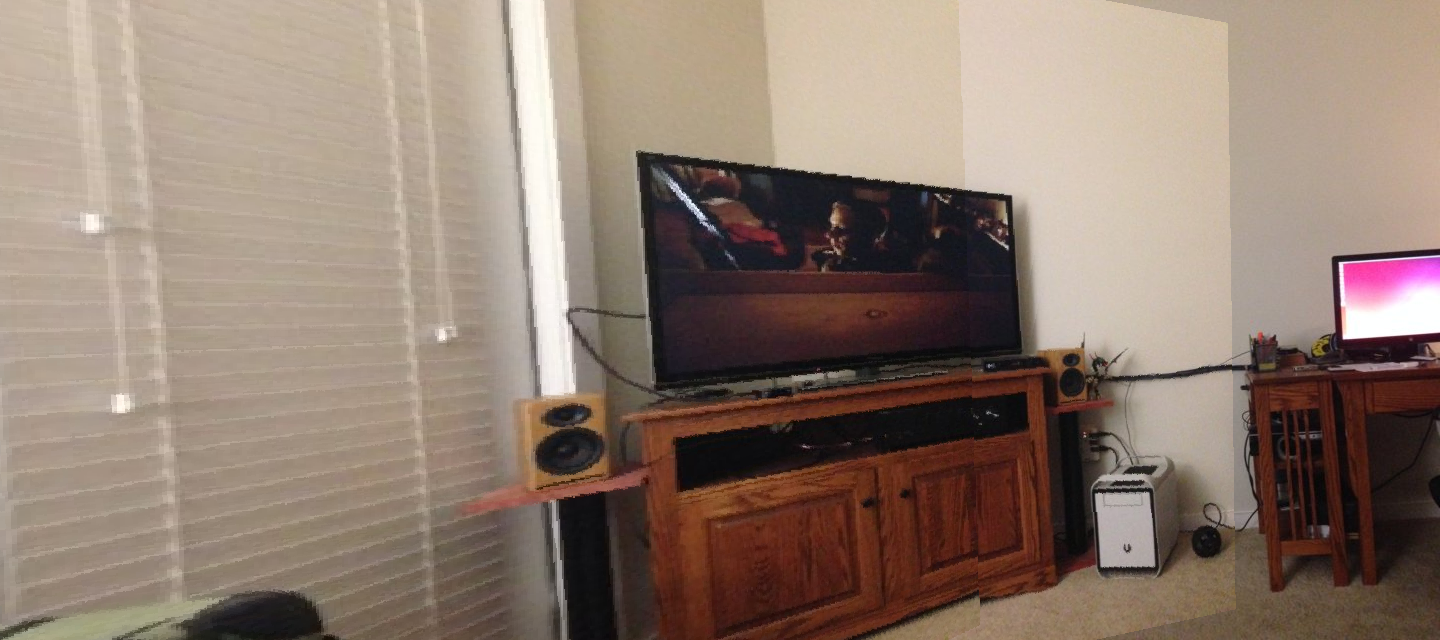

In [6]:
image1= cv2.imread('/content/tv/1.jpg')
image2= cv2.imread('/content/tv/2.jpg')
image3= cv2.imread('/content/tv/3.jpg')

for i in range(2):
  good, kp1, kp2= get_keymatch(image1, image2)
  T1, T2, x1_hat, y1_hat, x2_hat, y2_hat = normalize(image1, image2, good, kp1, kp2)
  
  max_matches=0
  max_iters=1000
  best_H= np.zeros((3,3))
  for it in range(max_iters):
    H, ind= ransacH(x1_hat, y1_hat, x2_hat, y2_hat)
    matches= inlier(x1_hat, y1_hat, x2_hat, y2_hat, H)
    if matches> max_matches:
      max_matches= matches
      final_ind=ind
      # print("Iter:", it, "match length:", max_matches)
      # print('------')
      best_H= H
  # print('Normalized H:', best_H)
  final_H= np.linalg.inv(T2.astype(np.float64)) @ best_H @ T1
  st_img= warp_img(image1, image2, final_H)
  if i !=1:
    print('denormalized matrix, first warp:',final_H)
    image1= st_img
    image2= image3
    cv2_imshow(st_img)  
  else:
    print('denormalized matrix, second warp:',final_H)
    res=st_img
    cv2_imshow(res)
